In [21]:
# Modèle 3 : LSTM

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import yfinance

import warnings
warnings.filterwarnings('ignore')

import os
import random
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import EarlyStopping


###### package courant pour le machine learning ######

import scipy
print('scipy: %s' % scipy.__version__)
# numpy
import numpy
print('numpy: %s' % numpy.__version__)
# matplotlib
import matplotlib
print('matplotlib: %s' % matplotlib.__version__)
# pandas
import pandas
print('pandas: %s' % pandas.__version__)
# statsmodels
import statsmodels
print('statsmodels: %s' % statsmodels.__version__)
# scikit-learn
import sklearn
print('sklearn: %s' % sklearn.__version__)

# # theano
# import theano
# print('theano: %s' % theano.__version__)
# tensorflow
import tensorflow
print('tensorflow: %s' % tensorflow.__version__)
# keras
import keras
print('keras: %s' % keras.__version__)



scipy: 1.15.3
numpy: 2.3.1
matplotlib: 3.10.3
pandas: 2.3.0
statsmodels: 0.14.4
sklearn: 1.7.0
tensorflow: 2.20.0
keras: 3.10.0


In [ ]:
data = pd.read_csv('data/df.csv',sep='|')
data['date'] = pd.to_datetime(data['date'])

#plt.figure(figsize=(12, 6))
#plt.plot(ts)
#plt.title('Prix journaliers du S&P500')
#plt.show()

DXY = yfinance.download('DX-Y.NYB', start='1999-01-04', end='2025-09-19')
DXY = DXY.reset_index()[['Date','Close']]
DXY.columns = ['date','DXY']
data=data.merge(DXY, on='date', how='left')

GDPM = pd.read_csv('GDP Monthly.csv',sep=',')
GDPM['date'] = pd.to_datetime(GDPM['timestamp'])
GDPM['year'] = GDPM['date'].dt.year
GDPM['month'] = GDPM['date'].dt.month
GDPM['CroissM'] = GDPM['EIA/GDPQXUS/USA'].diff()

# GDPQ = pd.read_csv('GDP Quarter.csv',sep=',')
# GDPQ['date'] = pd.to_datetime(GDPQ['timestamp'])
# GDPQ['year'] = GDPQ['date'].dt.year
# GDPQ['month'] = GDPQ['date'].dt.month

# GDPQ_full = []
# for _, row in GDPQ.iterrows():
#     for m in range(row['date'].quarter * 3 - 2, row['date'].quarter * 3 + 1):
#         GDPQ_full.append({'year': row['year'], 'month': m, 'CroissQ': row['CroissQ']})
# GDPQ_full = pd.DataFrame(GDPQ_full)


data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month

data = data.merge(GDPM, on=['year', 'month'], how='left')
#data = data.merge(GDPQ, on=['year', 'month'], how='left')
#data.drop(['timestamp_x','date_y','timestamp_y', 'date'], axis=1, inplace=True)
data.drop(['timestamp','date_y','year','month'], axis=1, inplace=True)
data['DXY'].fillna(method='ffill', inplace=True)
data.rename(columns = {'date_x': 'date'}, inplace = True)
data.set_index('date', inplace=True)
# data['mid'] = (data['high'] + data['low']) / 2
# data['range'] = data['high'] -data['low']

data.columns = data.columns.str.lower()

dataa = data.copy()

[*********************100%***********************]  1 of 1 completed


In [38]:
import time

In [ ]:
# Fixer la graine pour Python, NumPy, et TensorFlow


seed = int(time.time()) % 2**32  # ou random.randint(0, 2**32 - 1)
# 1759607359

# Fixer le seed
random.seed(seed)
np.random.seed(seed)
tensorflow.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# Afficher le seed utilisé
print(f"Seed utilisé pour cette exécution : {seed}")

# (Optionnel) Forcer une exécution déterministe
# Cela peut ralentir l'entraînement, mais rend encore plus reproductible
# os.environ["TF_DETERMINISTIC_OPS"] = "1"


df = dataa.copy()

early_stop = EarlyStopping(
    monitor='val_loss',   # Sur quelle métrique surveiller l'amélioration
    patience=30,          # Nombre d'époques sans amélioration avant arrêt
    verbose=1,            # Affiche un message quand l'arrêt se produit
    restore_best_weights=True  # Restaure les poids correspondant à la meilleure val_loss
)

# Paramètres
seq_len = 15  # Longueur de séquence temporelle

# Normalisation
scaler = MinMaxScaler()
data = scaler.fit_transform(df)

# Création des séquences
X, y = [], []
for i in range(len(data) - seq_len):
    X.append(data[i:i+seq_len])
    y.append(data[i+seq_len, df.columns.get_loc('cible')])
X, y = np.array(X), np.array(y)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Modèle LSTM
model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_len, df.shape[1])),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Entraînement
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stop])

# Prédiction
predictions = model.predict(X_test)

Seed utilisé pour cette exécution : 1759607359
Epoch 1/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0032 - val_loss: 7.4216e-04
Epoch 2/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0533e-04 - val_loss: 6.9007e-04
Epoch 3/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.6566e-05 - val_loss: 6.3705e-04
Epoch 4/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.4886e-05 - val_loss: 5.6637e-04
Epoch 5/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.8681e-05 - val_loss: 4.9377e-04
Epoch 6/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.3093e-05 - val_loss: 4.9149e-04
Epoch 7/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.1903e-05 - val_loss: 5.1051e-04
Epoch 8/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.0043e-05 - val_loss: 4.9756e-04
Epoch 9/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.7920e-05 - val_loss: 4.8111e-04
Epoch 10/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.6631e-05 - val_loss: 4.6509e-04
Epoch 11/50
168/

MSE: 10688.8105
MAE: 81.0845
R²: 0.9856
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

Prochaine valeur prédite: 6663.6234


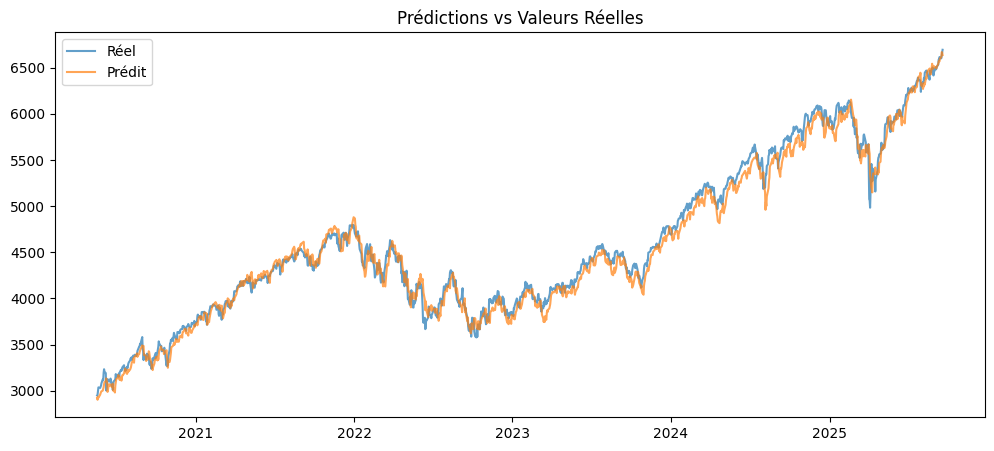

In [40]:
# Dénormaliser les prédictions
cible_idx = df.columns.get_loc('cible')
pred_denorm = scaler.inverse_transform(np.concatenate([np.zeros((len(predictions), cible_idx)), 
                                                        predictions, 
                                                        np.zeros((len(predictions), df.shape[1]-cible_idx-1))], axis=1))[:, cible_idx]
y_test_denorm = scaler.inverse_transform(np.concatenate([np.zeros((len(y_test), cible_idx)), 
                                                          y_test.reshape(-1,1), 
                                                          np.zeros((len(y_test), df.shape[1]-cible_idx-1))], axis=1))[:, cible_idx]

# Évaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print(f"MSE: {mean_squared_error(y_test_denorm, pred_denorm):.4f}")
print(f"MAE: {mean_absolute_error(y_test_denorm, pred_denorm):.4f}")
print(f"R²: {r2_score(y_test_denorm, pred_denorm):.4f}")

# Prédire le prochain point (future)
derniere_seq = data[-seq_len:].reshape(1, seq_len, df.shape[1])
next_pred = model.predict(derniere_seq)
next_pred_denorm = scaler.inverse_transform(np.concatenate([np.zeros((1, cible_idx)), 
                                                             next_pred, 
                                                             np.zeros((1, df.shape[1]-cible_idx-1))], axis=1))[0, cible_idx]
print(f"\nProchaine valeur prédite: {next_pred_denorm:.4f}")

# Visualisation (optionnel)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(df.iloc[-len(y_test_denorm):].index, y_test_denorm, label='Réel', alpha=0.7)
plt.plot(df.iloc[-len(y_test_denorm):].index, pred_denorm, label='Prédit', alpha=0.7)
plt.legend()
plt.title('Prédictions vs Valeurs Réelles')
plt.show()

In [37]:
# wsl --install
# nvidia-smi

import tensorflow as tf

# Liste les devices physiques disponibles
print("Devices disponibles :", tf.config.list_physical_devices())

# Vérifie si un GPU est utilisé par défaut
print("GPU dispo :", tf.config.list_physical_devices('GPU'))

# Affiche le device choisi automatiquement par TF
print("Device par défaut :", tf.test.gpu_device_name())


Devices disponibles : [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
GPU dispo : []
Device par défaut : 


In [35]:
import tensorflow as tf
print(tf.__version__)


2.20.0


In [7]:
results = pd.concat([pd.DataFrame(df.iloc[-len(y_test_denorm):].index, columns = ['date']), pd.DataFrame(pred_denorm, columns = ['pred']), pd.DataFrame(y_test_denorm, columns = ['real'])], axis=1)
results['diff'] = results['real'] - results['pred']
results

,date,pred,real,diff
0,2020-05-19,2929.098253,2948.51,19.411747
1,2020-05-20,2927.381375,2955.45,28.068625
2,2020-05-21,2942.930472,2991.77,48.839528
3,2020-05-22,2957.051408,3036.13,79.078592
4,2020-05-26,2965.130453,3029.73,64.599547
...,...,...,...,...
1336,2025-09-12,6761.935196,6606.76,-155.175196
1337,2025-09-15,6727.049613,6600.35,-126.699613
1338,2025-09-16,6799.317012,6631.96,-167.357012
1339,2025-09-17,6780.448929,6664.36,-116.088929


In [8]:
pd.DataFrame(df.columns).head()

,0
0,close
1,volume
2,high
3,low
4,pe


In [ ]:
from pandas import read_csv
from matplotlib import pyplot as plt
# load dataset
dataset = df.iloc[:500].copy()
values = dataset.values
# specify columns to plot
groups = [0, 1, 29]
i = 1

fig, axes = plt.subplots(len(groups), 1, figsize=(10, 6), sharex=True)

for i, group in enumerate(groups):
    axes[i].plot(dataset.index, values[:, group])
    axes[i].set_title(dataset.columns[group], y=0.5, loc='right')

# rotation des ticks seulement en bas
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

df = dataa.copy()

early_stop = EarlyStopping(
    monitor='val_loss',   # Sur quelle métrique surveiller l'amélioration
    patience=30,          # Nombre d'époques sans amélioration avant arrêt
    verbose=1,            # Affiche un message quand l'arrêt se produit
    restore_best_weights=True  # Restaure les poids correspondant à la meilleure val_loss
)

# Normalisation
scaler = MinMaxScaler()
data = scaler.fit_transform(df)


best_val_loss = float('inf')
best_seq_len = None

seq_lens = [5, 10, 15, 20, 30]

for seq_len in seq_lens:
    # Création des séquences
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len, df.columns.get_loc('cible')])
    X, y = np.array(X), np.array(y)
    
    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    # Définir le modèle
    model = Sequential([
        LSTM(50, activation='tanh', input_shape=(seq_len, df.shape[1])),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    
    # Entraînement
    history = model.fit(
        X_train, y_train,
        epochs=50, batch_size=32,
        validation_data=(X_test, y_test),
        verbose=0,
        callbacks=[early_stop]
    )
    
    val_loss = min(history.history['val_loss'])
    print(f"seq_len={seq_len}, val_loss={val_loss}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_seq_len = seq_len

print(f"\nMeilleur seq_len: {best_seq_len} avec val_loss: {best_val_loss}")


Restoring model weights from the end of the best epoch: 49.
seq_len=5, val_loss=0.0006986752268858254
Epoch 39: early stopping
Restoring model weights from the end of the best epoch: 9.
seq_len=10, val_loss=0.0009352253982797265
Restoring model weights from the end of the best epoch: 50.
seq_len=15, val_loss=0.0025745672173798084
Epoch 41: early stopping
Restoring model weights from the end of the best epoch: 11.
seq_len=20, val_loss=0.0012468186905607581
Restoring model weights from the end of the best epoch: 50.
seq_len=30, val_loss=0.0005841217935085297

Meilleur seq_len: 30 avec val_loss: 0.0005841217935085297


In [46]:
import random
import numpy as np
import tensorflow as tf
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# --- Générer un seed aléatoire pour cette exécution ---
seed = int(time.time()) % 2**32
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
print(f"Seed utilisé pour cette exécution : {seed}")

# --- Préparer les données ---
df = dataa.copy()
scaler = MinMaxScaler()
data = scaler.fit_transform(df)

# --- Hyperparamètres à tester ---
seq_lens = [5, 10, 15, 20, 30]
units_list = [32, 50, 100]
batch_sizes = [16, 32, 64]
learning_rates = [0.001, 0.0005]

# --- EarlyStopping commun ---
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=30,
    verbose=0,
    restore_best_weights=True
)

# --- Suivi du meilleur modèle ---
best_val_loss = float('inf')
best_model_params = {}

# --- Boucle sur tous les hyperparamètres ---
for seq_len in seq_lens:
    # Création des séquences
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len, df.columns.get_loc('cible')])
    X, y = np.array(X), np.array(y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    for units in units_list:
        for batch_size in batch_sizes:
            for lr in learning_rates:
                # Réinitialiser le seed pour chaque combinaison
                random.seed(seed)
                np.random.seed(seed)
                tf.random.set_seed(seed)
                
                # Créer le modèle
                model = Sequential([
                    LSTM(units, activation='relu', input_shape=(seq_len, df.shape[1])),
                    Dense(1)
                ])
                model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')
                
                # Entraîner
                history = model.fit(
                    X_train, y_train,
                    epochs=200,
                    batch_size=batch_size,
                    validation_data=(X_test, y_test),
                    verbose=0,
                    callbacks=[early_stop]
                )
                
                val_loss = min(history.history['val_loss'])
                print(f"seq_len={seq_len}, units={units}, batch_size={batch_size}, lr={lr}, val_loss={val_loss:.6f}")
                
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model_params = {
                        'seq_len': seq_len,
                        'units': units,
                        'batch_size': batch_size,
                        'learning_rate': lr,
                        'seed': seed,
                        'model': model
                    }

print("\nMeilleur modèle trouvé :")
print(best_model_params)
print(f"Validation Loss : {best_val_loss:.6f}")

# --- Pour reproduire ce modèle ---
best_seq_len = best_model_params['seq_len']
best_units = best_model_params['units']
best_batch_size = best_model_params['batch_size']
best_lr = best_model_params['learning_rate']
best_seed = best_model_params['seed']
best_model = best_model_params['model']

print(f"\nReproduire ce run avec seed : {best_seed} et seq_len : {best_seq_len}")


Seed utilisé pour cette exécution : 1759608945
seq_len=5, units=32, batch_size=16, lr=0.001, val_loss=0.000343
seq_len=5, units=32, batch_size=16, lr=0.0005, val_loss=0.002382
seq_len=5, units=32, batch_size=32, lr=0.001, val_loss=0.001041
seq_len=5, units=32, batch_size=32, lr=0.0005, val_loss=0.004187
seq_len=5, units=32, batch_size=64, lr=0.001, val_loss=0.001343
seq_len=5, units=32, batch_size=64, lr=0.0005, val_loss=0.001587
seq_len=5, units=50, batch_size=16, lr=0.001, val_loss=0.000154
seq_len=5, units=50, batch_size=16, lr=0.0005, val_loss=0.000674
seq_len=5, units=50, batch_size=32, lr=0.001, val_loss=0.000236
seq_len=5, units=50, batch_size=32, lr=0.0005, val_loss=0.001368
seq_len=5, units=50, batch_size=64, lr=0.001, val_loss=0.001290
seq_len=5, units=50, batch_size=64, lr=0.0005, val_loss=0.001832
seq_len=5, units=100, batch_size=16, lr=0.001, val_loss=0.000241
seq_len=5, units=100, batch_size=16, lr=0.0005, val_loss=0.000198
seq_len=5, units=100, batch_size=32, lr=0.001, v

Seed utilisé pour cette exécution : 1759608945
seq_len=5, units=32, batch_size=16, lr=0.001, val_loss=0.000343
seq_len=5, units=32, batch_size=16, lr=0.0005, val_loss=0.002382
seq_len=5, units=32, batch_size=32, lr=0.001, val_loss=0.001041
seq_len=5, units=32, batch_size=32, lr=0.0005, val_loss=0.004187
seq_len=5, units=32, batch_size=64, lr=0.001, val_loss=0.001343
seq_len=5, units=32, batch_size=64, lr=0.0005, val_loss=0.001587
seq_len=5, units=50, batch_size=16, lr=0.001, val_loss=0.000154
seq_len=5, units=50, batch_size=16, lr=0.0005, val_loss=0.000674
seq_len=5, units=50, batch_size=32, lr=0.001, val_loss=0.000236
seq_len=5, units=50, batch_size=32, lr=0.0005, val_loss=0.001368
seq_len=5, units=50, batch_size=64, lr=0.001, val_loss=0.001290
seq_len=5, units=50, batch_size=64, lr=0.0005, val_loss=0.001832
seq_len=5, units=100, batch_size=16, lr=0.001, val_loss=0.000241
seq_len=5, units=100, batch_size=16, lr=0.0005, val_loss=0.000198
seq_len=5, units=100, batch_size=32, lr=0.001, val_loss=0.000174
seq_len=5, units=100, batch_size=32, lr=0.0005, val_loss=0.000415
seq_len=5, units=100, batch_size=64, lr=0.001, val_loss=0.000212
seq_len=5, units=100, batch_size=64, lr=0.0005, val_loss=0.000724
seq_len=10, units=32, batch_size=16, lr=0.001, val_loss=0.000200
seq_len=10, units=32, batch_size=16, lr=0.0005, val_loss=0.000274
seq_len=10, units=32, batch_size=32, lr=0.001, val_loss=0.001671
seq_len=10, units=32, batch_size=32, lr=0.0005, val_loss=0.001777
seq_len=10, units=32, batch_size=64, lr=0.001, val_loss=0.001473
seq_len=10, units=32, batch_size=64, lr=0.0005, val_loss=0.002099
seq_len=10, units=50, batch_size=16, lr=0.001, val_loss=0.000159
seq_len=10, units=50, batch_size=16, lr=0.0005, val_loss=0.000460
seq_len=10, units=50, batch_size=32, lr=0.001, val_loss=0.001759
seq_len=10, units=50, batch_size=32, lr=0.0005, val_loss=0.000735
seq_len=10, units=50, batch_size=64, lr=0.001, val_loss=0.000561
seq_len=10, units=50, batch_size=64, lr=0.0005, val_loss=0.000742
seq_len=10, units=100, batch_size=16, lr=0.001, val_loss=0.000237
seq_len=10, units=100, batch_size=16, lr=0.0005, val_loss=0.000237
seq_len=10, units=100, batch_size=32, lr=0.001, val_loss=0.000230
seq_len=10, units=100, batch_size=32, lr=0.0005, val_loss=0.003050
seq_len=10, units=100, batch_size=64, lr=0.001, val_loss=0.001533
seq_len=10, units=100, batch_size=64, lr=0.0005, val_loss=0.000363
seq_len=15, units=32, batch_size=16, lr=0.001, val_loss=0.000253
seq_len=15, units=32, batch_size=16, lr=0.0005, val_loss=0.000674
seq_len=15, units=32, batch_size=32, lr=0.001, val_loss=0.000427
seq_len=15, units=32, batch_size=32, lr=0.0005, val_loss=0.001324
seq_len=15, units=32, batch_size=64, lr=0.001, val_loss=0.001082
seq_len=15, units=32, batch_size=64, lr=0.0005, val_loss=0.001493
seq_len=15, units=50, batch_size=16, lr=0.001, val_loss=0.000122
seq_len=15, units=50, batch_size=16, lr=0.0005, val_loss=0.000261
seq_len=15, units=50, batch_size=32, lr=0.001, val_loss=0.000273
seq_len=15, units=50, batch_size=32, lr=0.0005, val_loss=0.001535
seq_len=15, units=50, batch_size=64, lr=0.001, val_loss=0.000829
seq_len=15, units=50, batch_size=64, lr=0.0005, val_loss=0.002551
seq_len=15, units=100, batch_size=16, lr=0.001, val_loss=0.000183
seq_len=15, units=100, batch_size=16, lr=0.0005, val_loss=0.000247
seq_len=15, units=100, batch_size=32, lr=0.001, val_loss=0.000331
seq_len=15, units=100, batch_size=32, lr=0.0005, val_loss=0.000600
seq_len=15, units=100, batch_size=64, lr=0.001, val_loss=0.000793
seq_len=15, units=100, batch_size=64, lr=0.0005, val_loss=0.000892
seq_len=20, units=32, batch_size=16, lr=0.001, val_loss=0.000608
seq_len=20, units=32, batch_size=16, lr=0.0005, val_loss=0.000315
seq_len=20, units=32, batch_size=32, lr=0.001, val_loss=0.000399
seq_len=20, units=32, batch_size=32, lr=0.0005, val_loss=0.001801
seq_len=20, units=32, batch_size=64, lr=0.001, val_loss=0.001289
seq_len=20, units=32, batch_size=64, lr=0.0005, val_loss=0.001740
seq_len=20, units=50, batch_size=16, lr=0.001, val_loss=0.000227
seq_len=20, units=50, batch_size=16, lr=0.0005, val_loss=0.001702
seq_len=20, units=50, batch_size=32, lr=0.001, val_loss=0.000700
seq_len=20, units=50, batch_size=32, lr=0.0005, val_loss=0.002068
seq_len=20, units=50, batch_size=64, lr=0.001, val_loss=0.001321
seq_len=20, units=50, batch_size=64, lr=0.0005, val_loss=0.001295
seq_len=20, units=100, batch_size=16, lr=0.001, val_loss=0.000265
seq_len=20, units=100, batch_size=16, lr=0.0005, val_loss=0.000261
seq_len=20, units=100, batch_size=32, lr=0.001, val_loss=0.000306
seq_len=20, units=100, batch_size=32, lr=0.0005, val_loss=0.001122
seq_len=20, units=100, batch_size=64, lr=0.001, val_loss=0.002296
seq_len=20, units=100, batch_size=64, lr=0.0005, val_loss=0.001424
seq_len=30, units=32, batch_size=16, lr=0.001, val_loss=0.000589
seq_len=30, units=32, batch_size=16, lr=0.0005, val_loss=0.000736
seq_len=30, units=32, batch_size=32, lr=0.001, val_loss=0.001370
seq_len=30, units=32, batch_size=32, lr=0.0005, val_loss=0.000795
seq_len=30, units=32, batch_size=64, lr=0.001, val_loss=0.000547
seq_len=30, units=32, batch_size=64, lr=0.0005, val_loss=0.001863
seq_len=30, units=50, batch_size=16, lr=0.001, val_loss=0.000118
seq_len=30, units=50, batch_size=16, lr=0.0005, val_loss=0.000600
seq_len=30, units=50, batch_size=32, lr=0.001, val_loss=0.001509
seq_len=30, units=50, batch_size=32, lr=0.0005, val_loss=0.001933
seq_len=30, units=50, batch_size=64, lr=0.001, val_loss=0.000827
seq_len=30, units=50, batch_size=64, lr=0.0005, val_loss=0.000723
seq_len=30, units=100, batch_size=16, lr=0.001, val_loss=0.000140
seq_len=30, units=100, batch_size=16, lr=0.0005, val_loss=0.000175
seq_len=30, units=100, batch_size=32, lr=0.001, val_loss=0.000110
seq_len=30, units=100, batch_size=32, lr=0.0005, val_loss=0.000420
seq_len=30, units=100, batch_size=64, lr=0.001, val_loss=0.002057
seq_len=30, units=100, batch_size=64, lr=0.0005, val_loss=0.000595

Meilleur modèle trouvé :
{'seq_len': 30, 'units': 100, 'batch_size': 32, 'learning_rate': 0.001, 'seed': 1759608945, 'model': <Sequential name=sequential_103, built=True>}
Validation Loss : 0.000110

Reproduire ce run avec seed : 1759608945 et seq_len : 30